<a href="https://colab.research.google.com/github/sangse/Stock-AI/blob/main/%EC%8B%A0%EA%B7%9C%EC%83%81%EC%9E%A5%EC%A2%85%EB%AA%A9_%ED%8C%A8%ED%84%B4_Classification_%EB%AA%A8%EB%8D%B8_(with_CNN%2C_Kmeans).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classfication Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [ ]:
def df_slicing_window(df, window_size, shift_size):
  total_length = len(df)
  # 항상 마지막 부분까지 포함하기 위해 올림을 사용
  numofblock = math.ceil((total_length - window_size) / shift_size) + 1
  # 데이터 블럭들을 저장하는 리스트
  data_list = []
  target_list = []
  for num in range(numofblock):
      start_index = num * shift_size
      end_index = start_index + window_size
      # 인덱스 범위가 데이터 길이를 초과하지 않도록 처리

      if end_index > total_length:
          break
      data_list.append(df.iloc[start_index:end_index])
      target_list.append(df.iloc[end_index:end_index+12])
  return data_list#,target_list

## Data preprocessing & Extraction

In [ ]:

# 디렉토리 경로
directory = '/content/drive/MyDrive/data/신규상장데이터'

# 해당 디렉토리 안의 파일 이름들을 리스트로 가져옴
file_names = os.listdir(directory)

min_max_scaler = MinMaxScaler()

train_data = []
target_data = []


for name in file_names:
  # 파일 데이터프레임으로 저장하고 일자를 인덱스를 정립하고 오름차순으로 정렬. 상장후 4달치 약 81개 데이터
  tmp = pd.read_csv(os.path.join(directory, name),encoding='cp949')#.head(81)
  # tmp['일자'] = pd.to_datetime(tmp['일자'],format='%Y%m%d')
  tmp = tmp.sort_values(by='일자',ascending=True)
  tmp.set_index('일자',inplace=True)

  if any(tmp['공모가'] == None):
    continue

  # 공모가 대비 가격 특징 추가
  tmp['공모가대비현재가'] = tmp['현재가']/tmp['공모가']
  tmp['공모가대비저가'] = tmp['저가']/tmp['공모가']
  tmp['공모가대비고가'] = tmp['고가']/tmp['공모가']
  tmp['공모가대비시가'] = tmp['시가']/tmp['공모가']
  # Minmax scaler
  tmp['현재가'] = min_max_scaler.fit_transform(tmp[['현재가']])
  tmp['저가'] = min_max_scaler.fit_transform(tmp[['저가']])
  tmp['고가'] = min_max_scaler.fit_transform(tmp[['고가']])
  tmp['시가'] = min_max_scaler.fit_transform(tmp[['시가']])
  tmp['거래량'] = min_max_scaler.fit_transform(tmp[['거래량']])
  tmp['거래대금'] = min_max_scaler.fit_transform(tmp[['거래대금']])


  # 조건 검사: 공모가 대비 현재가가 5를 초과하는지 확인
  if any(tmp['공모가대비현재가'] > 5):
      print(f"{name}: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.")
      print(tmp['공모가'])


  # # 공모가대비현재가를 제일 첫번째 인덱스로 설정
  col = tmp.pop('공모가대비현재가')
  tmp.insert(0,'공모가대비현재가',col)

  # 필요없는 특징들은 제거
  drop_list = [	'종목코드','Unnamed: 0','종목명','시장구분','공모가']
  tmp.drop(drop_list,axis=1,inplace=True)


  # NaN 값이 하나라도 있으면 건너뛰기
  if tmp.isna().any().any():
      continue
  # 데이터를 window size 24 , shift_size 5로 잘라준다.
  train_data += df_slicing_window(tmp,12,2)

train_data = np.array(train_data)

## CNN Encoder Decoder Model Define

In [14]:
# train set batch*24*10

# 인코더 정의
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # MaxPooling 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # MaxPooling 추가

        self.flatten = nn.Flatten(start_dim=1)
        # 풀링으로 인해 특성 맵 크기 재계산 필요
        # self.fc1 = nn.Linear(32 * 6 * 3, 10)  # 3차원 벡터 출력
        self.fc1 = nn.Linear(32 * 3 * 3, 10)  # 3차원 벡터 출력

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# 디코더 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.fc1 = nn.Linear(10, 32 * 6 * 3)
        self.fc1 = nn.Linear(10, 32 * 3 * 3)

        # 첫 번째 레이어 설정 변경 없음
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=(2,2), stride=2,padding=1,output_padding=1)
        # 두 번째 레이어 설정 변경
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=(5,3), stride=2,padding=1,output_padding=1)


    def forward(self, x):
        x = self.fc1(x)
        # x = x.view(-1, 32, 6, 3)  # 4차원 형태로 변환
        x = x.view(-1, 32, 3, 3)  # 4차원 형태로 변환

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        return x

# 손실 함수 정의 (RMSE)
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, input, target):
        return torch.sqrt(torch.mean((input - target) ** 2))


## Model parameter Setting

In [15]:

# 인코더와 디코더 인스턴스 생성
encoder = Encoder()
decoder = Decoder()

# 최적화 설정
criterion = RMSELoss()  # RMSE 손실 함수 사용
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)



# 데이터셋 준비 및 분할
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
total_size = len(train_data_tensor)
val_size = int(0.2 * total_size)  # 전체 데이터의 20%를 검증 데이터로 사용
train_size = total_size - val_size

train_dataset, val_dataset = random_split(train_data_tensor, [train_size, val_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


## Model Learning

In [ ]:

# 최고 손실 추적
best_val_loss = float('inf')

# 학습 루프
num_epochs = 300
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    for data in train_loader:
        optimizer.zero_grad()
        reconstructions = decoder(encoder(data))
        loss = criterion(reconstructions, data)
        loss.backward()
        optimizer.step()

    # 검증 과정
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_reconstructions = decoder(encoder(val_data))
            val_loss = criterion(val_reconstructions, val_data)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {avg_val_loss}')

    # 모델 저장: 검증 손실이 이전 최소값보다 작은 경우
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, '/content/drive/MyDrive/CNN_reconstruction_model.pth')
        print("모델 저장됨: Epoch {}, Validation Loss: {:.4f}".format(epoch + 1, avg_val_loss))


Epoch [1/300], Training Loss: 0.19937123358249664, Validation Loss: 0.21104590374010582
모델 저장됨: Epoch 1, Validation Loss: 0.2110
Epoch [2/300], Training Loss: 0.14170053601264954, Validation Loss: 0.143707567067058
모델 저장됨: Epoch 2, Validation Loss: 0.1437
Epoch [3/300], Training Loss: 0.1021166667342186, Validation Loss: 0.11499449803873345
모델 저장됨: Epoch 3, Validation Loss: 0.1150
Epoch [4/300], Training Loss: 0.09441797435283661, Validation Loss: 0.10808103145272643
모델 저장됨: Epoch 4, Validation Loss: 0.1081
Epoch [5/300], Training Loss: 0.10820715129375458, Validation Loss: 0.10657048722108205
모델 저장됨: Epoch 5, Validation Loss: 0.1066
Epoch [6/300], Training Loss: 0.08766083419322968, Validation Loss: 0.10317575020922555
모델 저장됨: Epoch 6, Validation Loss: 0.1032
Epoch [7/300], Training Loss: 0.10296301543712616, Validation Loss: 0.10002227320715233
모델 저장됨: Epoch 7, Validation Loss: 0.1000
Epoch [8/300], Training Loss: 0.072045236825943, Validation Loss: 0.09749438751626897
모델 저장됨: Epoch 

In [ ]:
# 모델 파라미터 불러오기
tt = torch.load('/content/drive/MyDrive/CNN_reconstruction_model.pth')
encoder.load_state_dict(tt['encoder_state_dict'])
decoder.load_state_dict(tt['decoder_state_dict'])
test = decoder(encoder(train_dataset.dataset[:32,:,:,:]))
sns.scatterplot(train_dataset.dataset[5,0,:,0].detach().numpy())
sns.scatterplot(test[5,0,:,0].detach().numpy())
plt.legend(labels=['Original', 'Reconstructed'])
plt.show()

## Clustering Model Define & Result

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


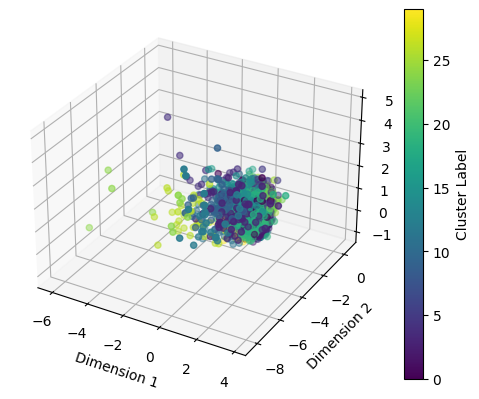

In [16]:
# 5차원 벡터이지만 비전으로 볼수 있게끔 3차원만 써서 clustering 했습니다.

import numpy as np
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Ensure the encoder is in evaluation mode
encoder.load_state_dict(torch.load('/content/drive/MyDrive/CNN_reconstruction_model.pth')['encoder_state_dict'])
encoder.eval()

# Get the vectors from the encoder
# Note: You might need to pass the data through DataLoader if it's too large to process at once
with torch.no_grad():
    vectors = encoder(train_dataset.dataset).detach().cpu().numpy()

# Perform K-means clustering
cluster_num = 30
kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(vectors)

# Extract cluster labels
labels = kmeans.labels_

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the encoded vectors, colored by cluster label
scatter = ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c=labels, cmap='viridis')

# Add a color bar to indicate cluster labels
colorbar = plt.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster Label')

# Set labels for axes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Show the plot
plt.show()


In [ ]:
# 라벨별로 데이터를 분류하기 위한 딕셔너리 초기화
clustered_datasets = {i: [] for i in range(cluster_num)}  # 클러스터 개수가 15개라고 가정

# 각 데이터 포인트를 해당 클러스터 라벨에 따라 분류
for idx, label in enumerate(labels):
    clustered_datasets[label].append(train_dataset.dataset[idx])

# 필요에 따라 각 클러스터 데이터셋을 Tensor로 변환 및 DataLoader로 래핑
for label in clustered_datasets:
    # 리스트를 Tensor로 변환
    clustered_datasets[label] = torch.stack(clustered_datasets[label])


In [ ]:
for k in clustered_datasets:
  print(clustered_datasets[k].shape)

torch.Size([103, 1, 12, 10])
torch.Size([1027, 1, 12, 10])
torch.Size([486, 1, 12, 10])
torch.Size([74, 1, 12, 10])
torch.Size([604, 1, 12, 10])
torch.Size([668, 1, 12, 10])
torch.Size([35, 1, 12, 10])
torch.Size([16, 1, 12, 10])
torch.Size([43, 1, 12, 10])
torch.Size([710, 1, 12, 10])
torch.Size([121, 1, 12, 10])
torch.Size([171, 1, 12, 10])
torch.Size([253, 1, 12, 10])
torch.Size([128, 1, 12, 10])
torch.Size([48, 1, 12, 10])
torch.Size([59, 1, 12, 10])
torch.Size([29, 1, 12, 10])
torch.Size([18, 1, 12, 10])
torch.Size([436, 1, 12, 10])
torch.Size([77, 1, 12, 10])
torch.Size([830, 1, 12, 10])
torch.Size([295, 1, 12, 10])
torch.Size([76, 1, 12, 10])
torch.Size([303, 1, 12, 10])
torch.Size([222, 1, 12, 10])
torch.Size([510, 1, 12, 10])
torch.Size([168, 1, 12, 10])
torch.Size([516, 1, 12, 10])
torch.Size([327, 1, 12, 10])
torch.Size([98, 1, 12, 10])


### Clustering Result

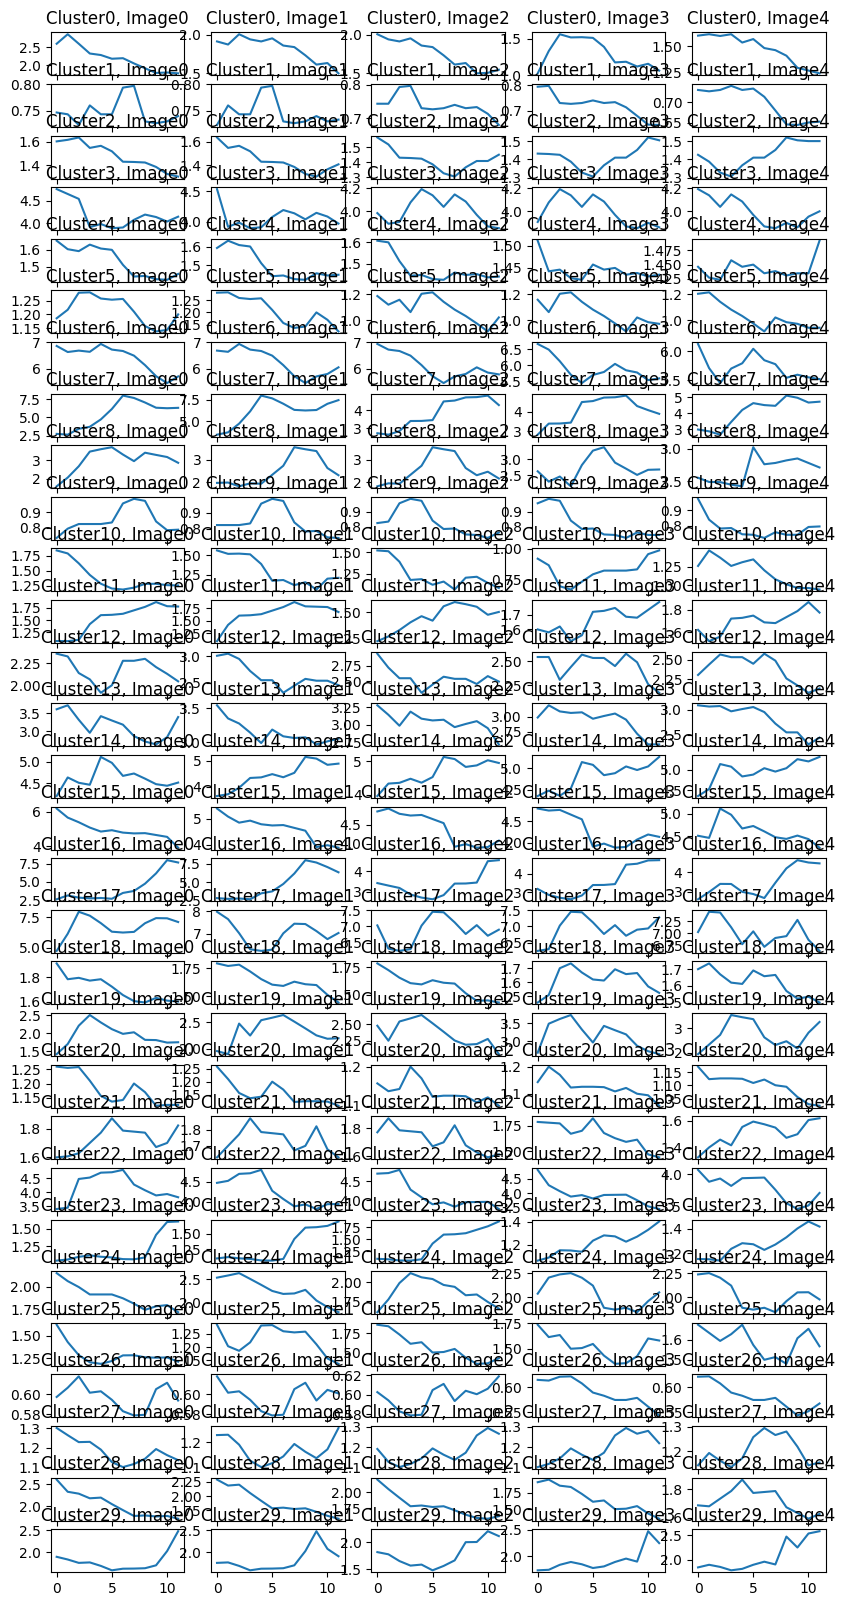

In [ ]:
# 각 군집의 5개 샘플 확인. encoder 10개 차원 벡터로 나온 clustering
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=cluster_num, ncols=5 ,figsize=(10, 20))
for k in range(cluster_num):
  for z in range(5):
    try:
      sns.lineplot(clustered_datasets[k][z,0,:,0],ax=axes[k][z])
      axes[k][z].set_title(f"Cluster{k}, Image{z}")
    except:
      pass
plt.show()

# Dlinear Model

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


## Date preprocessing & Extraction

In [24]:
def df_slicing_window_2(df, window_size, shift_size): # Dlinear 전용 생성기.
  total_length = len(df)
  # 항상 마지막 부분까지 포함하기 위해 올림을 사용
  numofblock = math.ceil((total_length - window_size) / shift_size) + 1
  # 데이터 블럭들을 저장하는 리스트
  data_list = []
  target_list = []
  for num in range(numofblock):
      start_index = num * shift_size
      end_index = start_index + window_size
      # 인덱스 범위가 데이터 길이를 초과하지 않도록 처리

      if end_index+12 > total_length:
          break

      data_list.append(df.iloc[start_index:end_index])
      target_list.append(df.iloc[end_index:end_index+12])
  return data_list,target_list

def df_slicing_window_2(df): # Transformer 전용 데이터생성기.
    total_length = len(df)
    data_array = []
    target_array = []
    for window_size in range(4, 13):
        numofblock = math.ceil((total_length - window_size) / 1) + 1
        for num in range(numofblock):
            start_index = num
            end_index = start_index + window_size
            if end_index + 12 > total_length:
                break
            data = df.iloc[start_index:end_index].values
            target = df.iloc[end_index:end_index+12].values
            data = np.pad(data, ((0, 12 - len(data)), (0, 0)), mode='constant')
            target = np.pad(target, ((0, 12 - len(target)), (0, 0)), mode='constant')
            data_array.append(data)
            target_array.append(target)
    return (data_array), (target_array)

def data_X_y_extraction():
  # 디렉토리 경로
  directory = '/content/drive/MyDrive/data/신규상장데이터'

  # 해당 디렉토리 안의 파일 이름들을 리스트로 가져옴
  file_names = os.listdir(directory)

  min_max_scaler = MinMaxScaler()

  train_data = []
  target_data = []


  for name in file_names:
    # 파일 데이터프레임으로 저장하고 일자를 인덱스를 정립하고 오름차순으로 정렬. 상장후 81일치 데이터만 사용.
    tmp = pd.read_csv(os.path.join(directory, name),encoding='cp949')
    # tmp['일자'] = pd.to_datetime(tmp['일자'],format='%Y%m%d')
    tmp = tmp.sort_values(by='일자',ascending=True)
    tmp.set_index('일자',inplace=True)

    # 공모가 대비 가격 특징 추가
    tmp['공모가대비현재가'] = tmp['현재가']/tmp['공모가']
    tmp['공모가대비저가'] = tmp['저가']/tmp['공모가']
    tmp['공모가대비고가'] = tmp['고가']/tmp['공모가']
    tmp['공모가대비시가'] = tmp['시가']/tmp['공모가']
    # Minmax scaler 81 주기를 바탕으로한 데이터이지만 최고가 갱신, 최저가 갱신이라면 이전 데이터는 무의미해진다.
    # 새로운 데이터를 넣어줄때 바로 문제점이 부각이 되네.
    tmp['현재가'] = min_max_scaler.fit_transform(tmp[['현재가']])
    tmp['저가'] = min_max_scaler.fit_transform(tmp[['저가']])
    tmp['고가'] = min_max_scaler.fit_transform(tmp[['고가']])
    tmp['시가'] = min_max_scaler.fit_transform(tmp[['시가']])
    tmp['거래량'] = min_max_scaler.fit_transform(tmp[['거래량']])
    tmp['거래대금'] = min_max_scaler.fit_transform(tmp[['거래대금']])


    # 공모가대비현재가를 제일 첫번째 인덱스로 설정
    col = tmp.pop('공모가대비현재가')
    tmp.insert(0,'공모가대비현재가',col)

    # 필요없는 특징들은 제거
    drop_list = [ '종목코드','Unnamed: 0','종목명','시장구분','공모가']
    tmp.drop(drop_list,axis=1,inplace=True)



    # NaN 값이 하나라도 있으면 건너뛰기
    if tmp.isna().any().any():
        continue
    # 데이터를 window size 12 , shift_size 4로 잘라준다.
    x,y = df_slicing_window_2(tmp)
    train_data += x
    target_data += y


  return np.asarray(train_data),np.asarray(target_data)
tmp_x,tmp_y = data_X_y_extraction()

In [25]:
np.asarray(tmp_x).shape,np.asarray(tmp_y).shape

((134290, 12, 10), (134290, 12, 10))

In [26]:
tmp_x = torch.tensor(tmp_x,dtype=torch.float32)
tmp_y = torch.tensor(tmp_y,dtype=torch.float32)
torch.save(tmp_x,'/content/drive/MyDrive/data/tmp_x_v2.pt')
torch.save(tmp_y,'/content/drive/MyDrive/data/tmp_y_v2.pt')

In [23]:
min_max_scaler = MinMaxScaler()

x_len = len(tmp_x)

total = torch.tensor(np.concatenate((tmp_x,tmp_y),axis=0), dtype=torch.float32).unsqueeze(1)
label = min_max_scaler.fit_transform(kmeans.predict(encoder(total).detach().numpy()).reshape(-1,1))
label = torch.tensor(label,dtype = torch.float32)
label = label.repeat_interleave(12,dim=1).unsqueeze(2)
total = torch.cat([total.squeeze(),label],dim=2).squeeze()
print(total.shape)
tmp_x_tensor = total[:x_len]
tmp_y_tensor = total[x_len:]

torch.save(tmp_x_tensor,'/content/drive/MyDrive/data/tmp_x_v2.pt')
torch.save(tmp_y_tensor,'/content/drive/MyDrive/data/tmp_y_v2.pt')

torch.Size([13938, 12, 11])


In [22]:
tmp_x_tensor.shape,tmp_y_tensor.shape

(torch.Size([6969, 12, 11]), torch.Size([6969, 12, 11]))

## Model Define

In [ ]:
# Clustering을 통해 각 데이터셋의 labeling이 가능하고, 이제 각 데이터 셋에대해서 다음 에 오는 데이터 라벨을 예측하는 모델을 구현 할 수 있다.
# 앞서 이용한 Encoder Block(CNN) 을 통해 feature를 뽑아내고 이 label들을 train ,target 에 특성으로 붙여주어 dataset 형성
# dataset을 Dlinear를 통해 실험.

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
    	# [BATCH SIZE, SEQ_LEN, CHANNEL]
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x # [BATCH SIZE, SEQ_LEN, CHANNEL]


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 3
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in
        self.linear = nn.Linear(self.channels, 1)

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        # seasonal_init: [Batch, Input length, Channel]
        # trend_init: [Batch, Input length, Channel]
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        # seasonal_init: [Batch, Channel, Input length]
        # trend_init: [Batch, Channel, Input length]
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)

            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        x = x.permute(0,2,1)
        x = self.linear(x)
        # x = x[:,:,:] # 현재가만 뽑아오기
        return  x# to [Batch, Output length, Channel]

## Data Setting & Model Config

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import argparse

config = argparse.Namespace(
    seq_len=12,  # 시퀀스 길이
    pred_len=12,  # 예측 길이
    individual=True,  # individual 설정
    enc_in=11  # 인코더 입력 채널 수
)



train_size = int(0.6 * len(tmp_x_tensor))
val_size = int(0.2 * len(tmp_x_tensor))
test_size = len(tmp_x_tensor) - train_size - val_size

# 데이터를 GPU로 이동시키기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train,X_val,y_train,y_val = train_test_split(tmp_x_tensor,tmp_y_tensor,test_size=0.4,shuffle=True)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val,test_size=0.5,shuffle=True)

X_train,X_val,y_train,y_val = X_train.to(device),X_val.to(device),y_train.to(device),y_val.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

# 각각의 데이터셋에 대해 TensorDataset을 생성
train_dataset = TensorDataset((X_train), (y_train))
val_dataset = TensorDataset((X_val), (y_val))
test_dataset = TensorDataset((X_test), (y_test))


# 각각의 데이터셋에 대해 DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=64,shuffle = True)

## Model Learning

In [ ]:
# 모델 정의
model = Model(config)
# GPU 사용 가능 여부 확인
print("Using device:", device)
# 모델을 GPU로 이동
# model.to(device)

# Adam 옵티마이저 설정
learning_rate = 0.001  # 학습률 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# 모델 가중치 업데이트

train_loss_list = []
valid_loss_list = []
test_loss_list = []

epochs = 300
max_loss = 999999999
for epoch in range(1,epochs+1):
  loss_list = []
  model.train()
  for x_bat, y_bat in train_loader:
    optimizer.zero_grad()  # 기울기 초기화
    outputs = model(x_bat)  # 모델 예측
    loss = criterion(outputs.squeeze(), y_bat[:,:,0])  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 매개변수 업데이트
    loss_list.append(loss.item())
  train_loss_list.append(np.mean(loss_list))


  model.eval()
  with torch.no_grad():
        for data, target in val_loader:
            output = model(data)

            valid_loss = criterion(output.squeeze(), target[:,:,0])
            valid_loss_list.append(valid_loss)

        for data, target in test_loader:
            output = model(data)
            test_loss = criterion(output.squeeze(), target[:,:,0])
            test_loss_list.append(test_loss)

        if valid_loss < max_loss:
            torch.save(model, '/content/drive/MyDrive/DLinear_model.pth')
            max_loss = valid_loss
            print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
            dlinear_best_epoch = epoch
            dlinear_best_train_loss = np.mean(loss_list)
            dlinear_best_valid_loss = np.mean(valid_loss.item())
            dlinear_best_test_loss = np.mean(test_loss.item())

  print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

Using device: cpu
valid_loss=0.146, test_los0.331, Model Save
epoch = 1, train_loss : 0.928, valid_loss : 0.146, test_loss : 0.331
valid_loss=0.117, test_los0.083, Model Save
epoch = 2, train_loss : 0.217, valid_loss : 0.117, test_loss : 0.083
valid_loss=0.086, test_los0.082, Model Save
epoch = 3, train_loss : 0.145, valid_loss : 0.086, test_loss : 0.082
epoch = 4, train_loss : 0.108, valid_loss : 0.151, test_loss : 0.069
valid_loss=0.054, test_los0.136, Model Save
epoch = 5, train_loss : 0.088, valid_loss : 0.054, test_loss : 0.136
valid_loss=0.035, test_los0.027, Model Save
epoch = 6, train_loss : 0.077, valid_loss : 0.035, test_loss : 0.027
epoch = 7, train_loss : 0.071, valid_loss : 0.055, test_loss : 0.133
epoch = 8, train_loss : 0.065, valid_loss : 0.057, test_loss : 0.029
epoch = 9, train_loss : 0.062, valid_loss : 0.039, test_loss : 0.108
valid_loss=0.028, test_los0.083, Model Save
epoch = 10, train_loss : 0.061, valid_loss : 0.028, test_loss : 0.083
epoch = 11, train_loss : 0.

## Model Loading & Testing

In [ ]:
model = (torch.load('/content/drive/MyDrive/DLinear_model.pth'))
model.eval()  # 모델을 평가 모드로 설정
d1 = []
d2 = []
d3 = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        d1.append(output[:,:,0])
        d2.append(target[:,:,0])
        d3.append(data[:,:,0])
        # test_loss = criterion(output, target)
        # test_loss_list.append(test_loss)


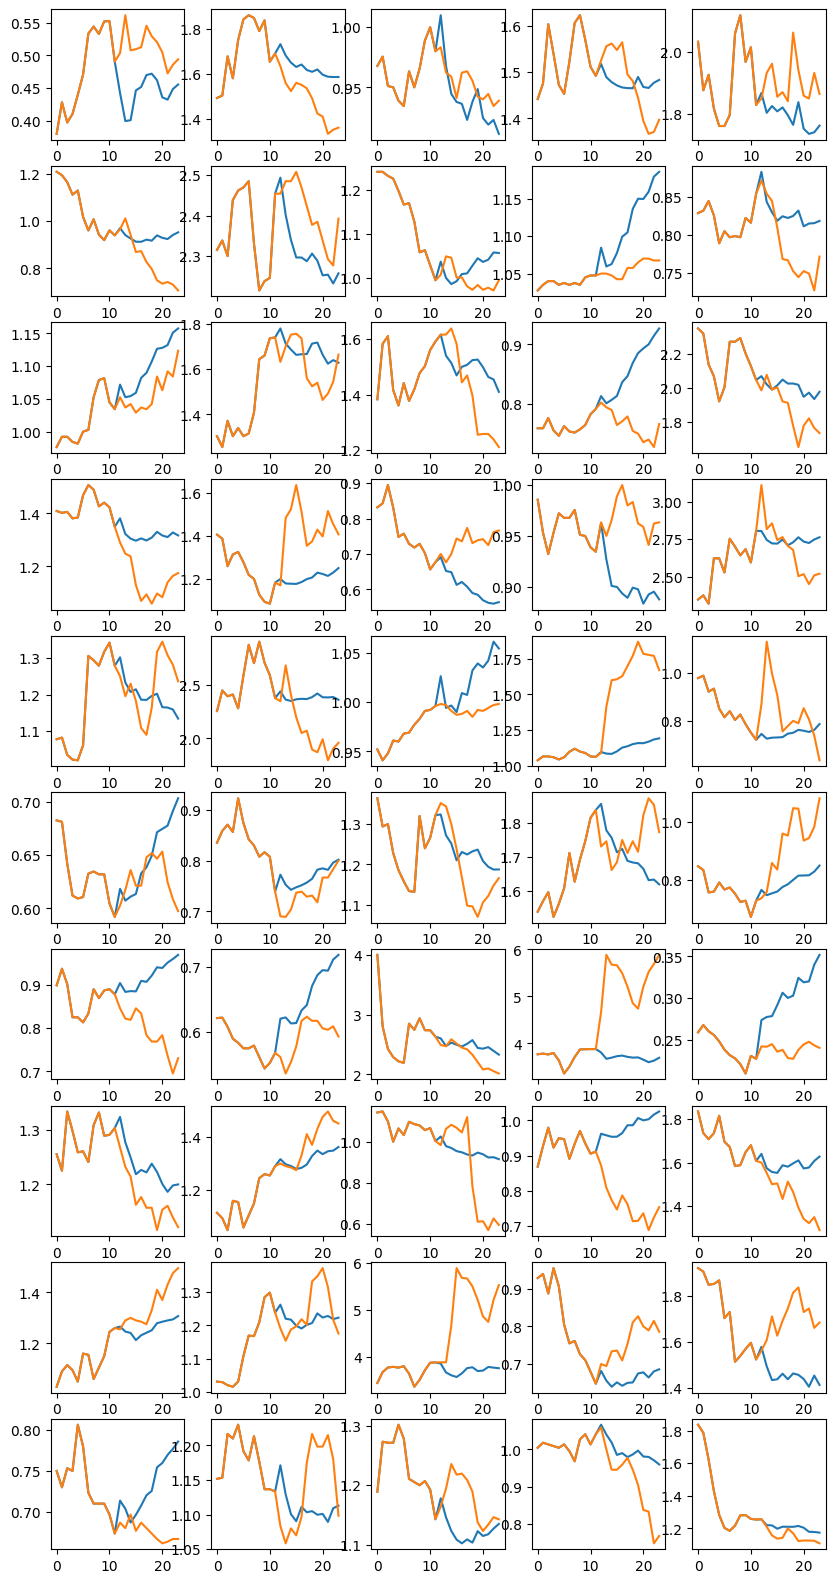

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=5 ,figsize=(10, 20))
for k in range(10,20):
  for z in range(10,15):
    try:
      pred = np.concatenate((d3[k][z],d1[k][z]),axis=0)
      origin = np.concatenate((d3[k][z],d2[k][z]),axis=0)
      sns.lineplot(pred,ax=axes[k-10][z-10])
      sns.lineplot(origin,ax=axes[k-10][z-10])
      # axes[k][z].set_title(f"Batch{k}, Image{z}")
      # axes[k][z].legend(["Output", "Target"])
    except:
      pass
plt.show()